In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
from scipy.spatial import Delaunay
import math
import random

### essais successifs

In [2]:
def validecorde(corde, drawn_chords):
    # Parcourir toutes les paires possibles de sommets
    (i,j) = corde
    # Vérifier si la corde i,j est déjà dessinée
    if (i,j) in drawn_chords:
            return False

    # Vérifier s'il y a une corde entre i,j qui croise une corde déjà dessinée
    else: 
        for (k, p) in drawn_chords:
           if k < i and i < p < j:
               return False

    # Si aucune corde n'est invalide, alors toutes les cordes sont valides
    return True


In [3]:
def trouver_toutes_les_triangulations(C):
    n = len(C)  # Le nombre de sommets dans le polygone
    deja_utilise = set()  # Un ensemble pour garder une trace des cordes déjà explorées
    triangulations = []  # La liste des triangulations trouvées

    def explorer_triangulations(i, dernier, triangulation):
        nonlocal deja_utilise  # On utilise deja_utilise de l'enclosing scope
        if i == n:  # Si on a exploré toutes les cordes, on a une triangulation complète
            yield triangulation
            return

        for j in range(i+1, n):  # Chercher les cordes valides partant du sommet i
            if validecorde((i, j), deja_utilise) :
                deja_utilise.add((i,j))  # Marquer la corde (i,j) comme utilisée
                triangulation.append((i,j))  # Ajouter la corde à la triangulation en cours
                yield from explorer_triangulations(i, j, triangulation)  # Explorer la suite de la triangulation
                deja_utilise.remove((i,j))  # Marquer la corde (i,j) comme non utilisée
                triangulation.pop()  # Enlever la corde de la triangulation en cours

        if dernier is not None:  # Si on est pas au dernier sommet, continuer l'exploration
            yield from explorer_triangulations(i+1, dernier, triangulation)

    # Démarrer l'exploration depuis le dernier sommet
    for i in range(0, n-1):
        if validecorde((n-2, i), deja_utilise) :
            deja_utilise.add((n-1,i))  # Marquer la corde (n-1,i) comme utilisée
            triangulation = [(n-1, i)]  # Initialiser la triangulation en cours avec la corde (n-1,i)
            triangulations.extend(list(explorer_triangulations(i, n-1, triangulation)))  # Explorer la triangulation en cours
            deja_utilise.remove((n-1,i))  # Marquer la corde (n-1,i) comme non utilisée

    return triangulations


In [4]:
def dessiner_triangulation(C, triangulations):
    """
    Dessine le polygone convexe décrit par C et les triangulations décrites par triangulations
    """
    # Dessiner le polygone convexe
    C = np.array(C)  # Transformer la liste de sommets en tableau numpy pour faciliter les calculs
    plt.plot(C[:,0], C[:,1], '-k', lw=2)

    # Dessiner les triangulations en couleurs
    for i, triangulation in enumerate(triangulations):
        color = plt.cm.tab20(i/len(triangulations))  # Générer une couleur différente pour chaque triangulation
        for a, b in triangulation:
            plt.plot([C[a][0], C[b][0]], [C[a][1], C[b][1]], '-', color=color, lw=2)

    plt.axis('equal')
    plt.show()


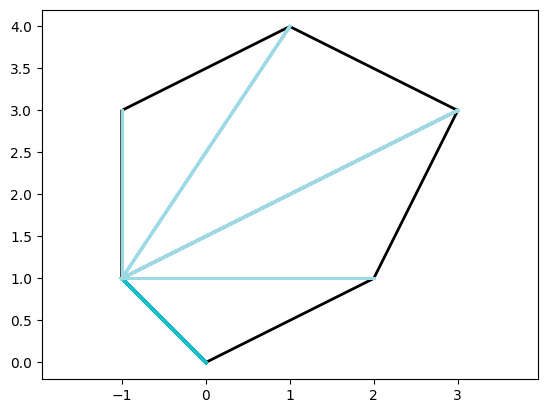

[[(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)], [(5, 0)],

In [5]:
C = [(0, 0), (2, 1), (3, 3), (1, 4), (-1, 3), (-1, 1)]
triangulations = trouver_toutes_les_triangulations(C)
dessiner_triangulation(C, triangulations)
print(triangulations)


### Dynamique

In [6]:
def triangulate_polygon(polygon):
    triangles = []
    n = len(polygon)
    
    # Si le nombre de sommets du polygone est inférieur à 3, il ne peut pas être triangulé
    if n < 3:
        return triangles
    
    # Parcourt tous les sommets du polygone
    for i in range(n):
        prev = (i - 1) % n
        curr = i
        next = (i + 1) % n
        
        # Vérifie si le triangle formé par les sommets i, i+1 et i+2 est une "oreille" du polygone
        if is_ear(polygon, prev, curr, next):
            # Ajoute le triangle à la liste des triangles et enlève le sommet i+1 du polygone
            triangles.append((polygon[prev], polygon[curr], polygon[next]))
            polygon.pop(curr)
            # Répète le processus de triangulation sur le polygone restant
            return triangles + triangulate_polygon(polygon)
    
    # Si aucun triangle n'a été trouvé pour trianguler le polygone, la triangulation est terminée
    return triangles


def is_ear(polygon, i, j, k):
    # Vérifie si le triangle formé par les sommets i, j et k ne contient pas d'autres sommets du polygone
    for m in range(len(polygon)):
        if m != i and m != j and m != k and is_inside_triangle(polygon[m], polygon[i], polygon[j], polygon[k]):
            return False
    return True


def is_inside_triangle(p, a, b, c):
    # Vérifie si le point p est à l'intérieur du triangle formé par les sommets a, b et c
    return is_same_side(p, a, b, c) and is_same_side(p, b, a, c) and is_same_side(p, c, a, b)


def is_same_side(p1, p2, a, b):
    # Vérifie si les points p1 et p2 sont du même côté de la ligne formée par les sommets a et b
    cp1 = cross_product(b[0] - a[0], b[1] - a[1], p1[0] - a[0], p1[1] - a[1])
    cp2 = cross_product(b[0] - a[0], b[1] - a[1], p2[0] - a[0], p2[1] - a[1])
    return cp1 * cp2 >= 0


def cross_product(x1, y1, x2, y2):
    # Calcule le produit vectoriel de deux vecteurs
    return x1 * y2 - x2 * y1



In [7]:
def draw_polygon_and_triangles(points, triangles, zoom_out=1.2):
    # Créer la figure et l'axe
    fig, ax = plt.subplots()

    # Dessiner le polygone
    poly = Polygon(points, facecolor='white', edgecolor='black')
    ax.add_patch(poly)

    # Dessiner chaque triangle avec une couleur aléatoire
    for triangle in triangles:
        color = (random.random(), random.random(), random.random())
        tri = Polygon(triangle, facecolor=color, edgecolor='black')
        ax.add_patch(tri)

    # Définir les limites de l'axe
    margin = max(1, max(abs(point[0]) for point in points), max(abs(point[1]) for point in points))
    ax.set_xlim([-margin*zoom_out, margin*zoom_out])
    ax.set_ylim([-margin*zoom_out, margin*zoom_out])

    # Afficher la figure
    plt.show()

[((276.3170853336246, 491.370066028904), (180.49111067193468, 494.6643076028935), (153.57298273821428, 491.8990116382506)), ((276.3170853336246, 491.370066028904), (153.57298273821428, 491.8990116382506), (124.90587499022688, 482.56823390821756)), ((276.3170853336246, 491.370066028904), (124.90587499022688, 482.56823390821756), (94.8304013738639, 465.4617906982039)), ((276.3170853336246, 491.370066028904), (94.8304013738639, 465.4617906982039), (79.65802095744523, 451.0048215906153)), ((276.3170853336246, 491.370066028904), (79.65802095744523, 451.0048215906153), (58.657721967764864, 430.7563139713908)), ((276.3170853336246, 491.370066028904), (58.657721967764864, 430.7563139713908), (22.125366180142493, 377.135118374759)), ((276.3170853336246, 491.370066028904), (22.125366180142493, 377.135118374759), (15.018875463509772, 340.6585145248268)), ((276.3170853336246, 491.370066028904), (15.018875463509772, 340.6585145248268), (7.423964246997095, 237.6564116158071)), ((276.3170853336246, 4

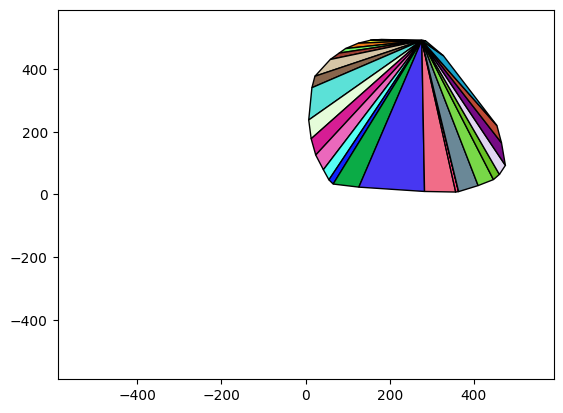

In [8]:
C = [
(180.49111067193468, 494.6643076028935)
,(153.57298273821428, 491.8990116382506)
,(124.90587499022688, 482.56823390821756)
,(94.8304013738639, 465.4617906982039)
,(79.65802095744523, 451.0048215906153)
,(58.657721967764864, 430.7563139713908)
,(22.125366180142493, 377.135118374759)
,(15.018875463509772, 340.6585145248268)
,(7.423964246997095, 237.6564116158071)
,(13.25404024697252, 177.78175687888677)
,(24.105947793609307, 125.83176826111064)
,(42.27962105864147, 78.94556462003533)
,(55.46466046939314, 46.68742678288962)
,(65.52681116466663, 33.29498410064791)
,(126.6137140781215, 23.464199508610008)
,(282.78977610022685, 9.617583587439471)
,(356.9265394776163, 7.778598135969372)
,(363.79596068265454, 9.146574531481711)
,(363.8598081309624, 9.168552444235868)
,(410.2550243605333, 28.412895732593867)
,(446.6594395588621, 47.50671199284218)
,(460.78665921087867, 64.044003818305)
,(475.03239783670716, 92.81868127186299)
,(465.8151124650581, 164.52408991617017)
,(454.9461041438435, 219.66632833107658)
,(327.8984491216154, 442.4023448567188)
,(285.1837042223283, 490.3952039723944)
,(281.86092750835576, 490.7914741816579)
,(276.3170853336246, 491.370066028904)]
triangles = triangulate_polygon(C)
print (triangles) 
draw_polygon_and_triangles(C, triangles)

### Greedy

In [9]:
def line_length(p1, p2):
    """
    Calculates the Euclidean distance between two 2D points p1 and p2.
    Returns a float.
    """
    x1, y1 = p1
    x2, y2 = p2
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)


In [10]:
def triangle_greedy(points):
    # Vérifier que les points forment un polygone convexe
    n = len(points)
    if n < 3:
        # Si la liste de points contient moins de 3 points, elle ne peut pas former un polygone convexe,
        # donc on retourne une liste vide
        return []

    # Initialiser la liste des triangles
    triangles = []

    # Tant qu'il reste des sommets à trianguler
    while n > 2:
        # Rechercher la corde extérieure la plus courte
        min_distance = float('inf')
        min_index = -1
        for i in range(n):
            p1 = points[i]
            p2 = points[(i+1)%n]
            for j in range(1, n-1):
                if j == i or j == (i+1)%n:
                    continue
                p3 = points[(i+j)%n]
                p4 = points[(i+j+1)%n]
                distance = line_length(p1, p3) + line_length(p2, p4)
                if distance < min_distance:
                    min_distance = distance
                    min_index = (i+j)%n

        # Ajouter le triangle formé par la corde extérieure
        triangles.append((points[min_index], points[(min_index+1)%n], points[(min_index-1)%n]))

        # Retirer le point sélectionné
        points.pop(min_index)
        n -= 1

    # Retourner la liste des triangles
    return triangles


In [11]:
def draw_polygon_and_triangles(points, triangles, zoom_out=1.2):
    # Créer la figure et l'axe
    fig, ax = plt.subplots()

    # Dessiner le polygone
    poly = Polygon(points, facecolor='white', edgecolor='black')
    ax.add_patch(poly)

    # Dessiner chaque triangle avec une couleur aléatoire
    for triangle in triangles:
        color = (random.random(), random.random(), random.random())
        tri = Polygon(triangle, facecolor=color, edgecolor='black')
        ax.add_patch(tri)

    # Définir les limites de l'axe
    margin = max(1, max(abs(point[0]) for point in points), max(abs(point[1]) for point in points))
    ax.set_xlim([-margin*zoom_out, margin*zoom_out])
    ax.set_ylim([-margin*zoom_out, margin*zoom_out])

    # Afficher la figure
    plt.show()

[((363.79596068265454, 9.146574531481711), (363.8598081309624, 9.168552444235868), (356.9265394776163, 7.778598135969372)), ((281.86092750835576, 490.7914741816579), (276.3170853336246, 491.370066028904), (285.1837042223283, 490.3952039723944)), ((79.65802095744523, 451.0048215906153), (58.657721967764864, 430.7563139713908), (94.8304013738639, 465.4617906982039)), ((55.46466046939314, 46.68742678288962), (65.52681116466663, 33.29498410064791), (42.27962105864147, 78.94556462003533)), ((460.78665921087867, 64.044003818305), (475.03239783670716, 92.81868127186299), (446.6594395588621, 47.50671199284218)), ((363.8598081309624, 9.168552444235868), (410.2550243605333, 28.412895732593867), (356.9265394776163, 7.778598135969372)), ((285.1837042223283, 490.3952039723944), (276.3170853336246, 491.370066028904), (327.8984491216154, 442.4023448567188)), ((94.8304013738639, 465.4617906982039), (58.657721967764864, 430.7563139713908), (124.90587499022688, 482.56823390821756)), ((446.6594395588621,

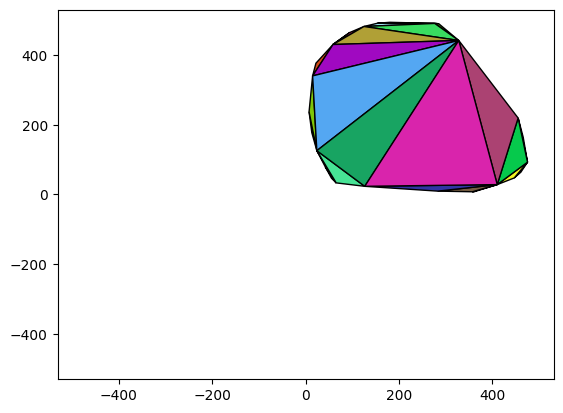

In [12]:
C = [
(180.49111067193468, 494.6643076028935)
,(153.57298273821428, 491.8990116382506)
,(124.90587499022688, 482.56823390821756)
,(94.8304013738639, 465.4617906982039)
,(79.65802095744523, 451.0048215906153)
,(58.657721967764864, 430.7563139713908)
,(22.125366180142493, 377.135118374759)
,(15.018875463509772, 340.6585145248268)
,(7.423964246997095, 237.6564116158071)
,(13.25404024697252, 177.78175687888677)
,(24.105947793609307, 125.83176826111064)
,(42.27962105864147, 78.94556462003533)
,(55.46466046939314, 46.68742678288962)
,(65.52681116466663, 33.29498410064791)
,(126.6137140781215, 23.464199508610008)
,(282.78977610022685, 9.617583587439471)
,(356.9265394776163, 7.778598135969372)
,(363.79596068265454, 9.146574531481711)
,(363.8598081309624, 9.168552444235868)
,(410.2550243605333, 28.412895732593867)
,(446.6594395588621, 47.50671199284218)
,(460.78665921087867, 64.044003818305)
,(475.03239783670716, 92.81868127186299)
,(465.8151124650581, 164.52408991617017)
,(454.9461041438435, 219.66632833107658)
,(327.8984491216154, 442.4023448567188)
,(285.1837042223283, 490.3952039723944)
,(281.86092750835576, 490.7914741816579)
,(276.3170853336246, 491.370066028904)]
triangles = triangle_greedy(C)
print(triangles)
draw_polygon_and_triangles(C, triangles)